## Data Scientist Capstone


### Price prediction in the AirBnB London Market

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from scipy import stats
#from scipy.stats import norm
import seaborn as sns
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.tree 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Imputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor


C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Reading in the csv files from http://insideairbnb.com/get-the-data.html

In [2]:
#I will only use the listings file for the model building, 
#but I will explore the calendar file to discuss improvements to be done regarding seasonality

listings = pd.read_csv('listings.csv')
#reviews = pd.read_csv('reviews.csv')
#calender from oct 18 to oct 19
calendar = pd.read_csv('calendar.csv')

C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Data Exploration and and Data Visualization

In [3]:
listings.shape

(74153, 96)

In [4]:
listings['price'].describe()

count      74153
unique       732
top       $50.00
freq        2778
Name: price, dtype: object

In [5]:
#convert price to float:
listings[['price']] = listings[['price']].replace('[\$,]','',regex=True).astype(float)

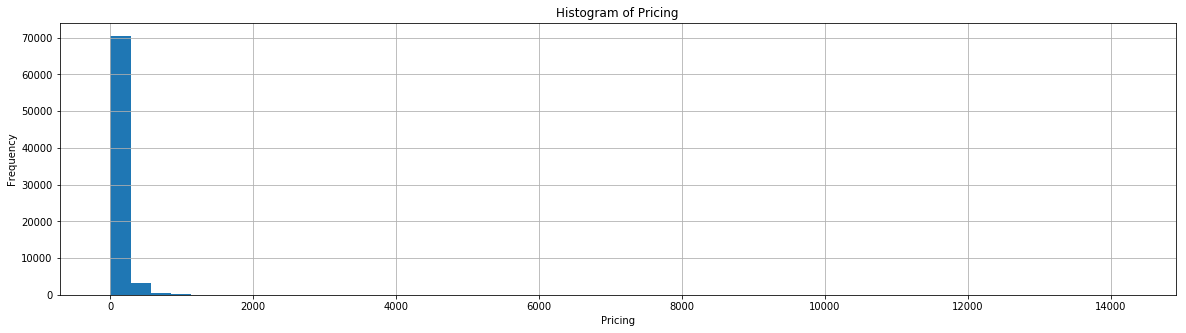

In [6]:
listings['price'].hist(bins=50, figsize = (20,5))
plt.title("Histogram of Pricing")
plt.xlabel("Pricing")
plt.ylabel("Frequency")
plt.show()

In [7]:
#removing outliers in the target feature, limit the price to below 400
listings = listings[listings['price']<=400]
listings = listings[listings['price']>0]

In [8]:
listings.shape

(72689, 96)

In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72689 entries, 0 to 74152
Data columns (total 96 columns):
id                                  72689 non-null int64
listing_url                         72689 non-null object
scrape_id                           72689 non-null int64
last_scraped                        72689 non-null object
name                                72662 non-null object
summary                             69992 non-null object
space                               49663 non-null object
description                         71785 non-null object
experiences_offered                 72689 non-null object
neighborhood_overview               44127 non-null object
notes                               28891 non-null object
transit                             44497 non-null object
access                              42453 non-null object
interaction                         40272 non-null object
house_rules                         43080 non-null object
thumbnail_url          

There are 60 columns of categorical data and 36 columns of numerical data.

In [10]:
#categorical variables
categorical = listings.select_dtypes(include=['object'])
categorical.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'license', 'instant_b

In [11]:
#numerical variables
numerical = listings.select_dtypes(include=['int64', 'float64'])
numerical.columns

Index(['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url',
       'host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'price', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

In [12]:
#descriptive statistics summary - target variable
listings['price'].describe()

count    72689.000000
mean        96.071579
std         70.593296
min          1.000000
25%         45.000000
50%         77.000000
75%        125.000000
max        400.000000
Name: price, dtype: float64

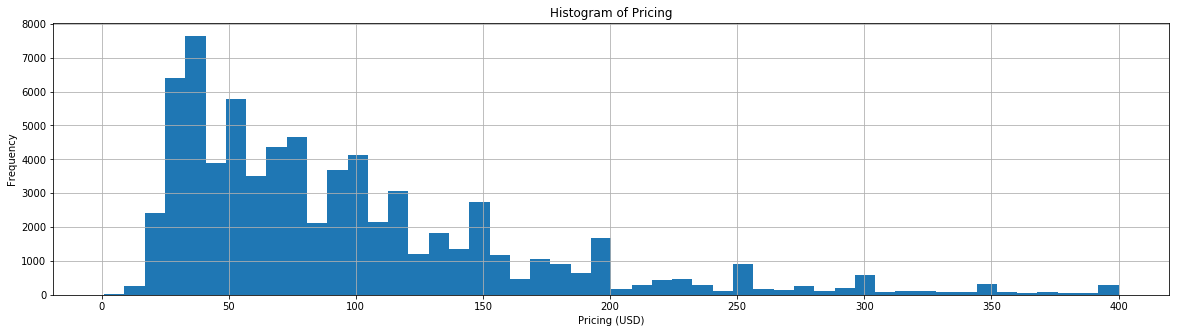

In [13]:
#price frequency
listings['price'].hist(bins=50, figsize = (20,5))
plt.title("Histogram of Pricing")
plt.xlabel("Pricing (USD)")
plt.ylabel("Frequency")
plt.show()

C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


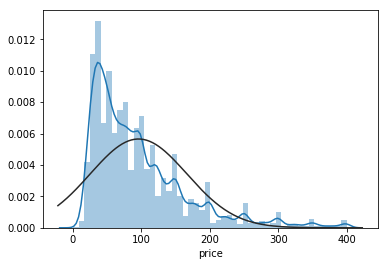

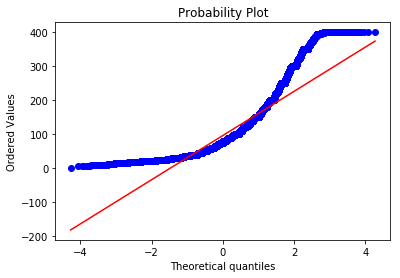

In [14]:
sns.distplot(listings['price'], fit=norm);
fig = plt.figure()
fig.savefig("price.png")
res = stats.probplot(listings['price'], plot=plt)
fig.savefig("prob.png")

In [15]:
listings['log_price'] = np.log(listings['price'])

In [16]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,log_price
0,9554,https://www.airbnb.com/rooms/9554,20181006000810,2018-10-06,"Cozy, 3 minutes to Piccadilly Line",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,"Hello people, This is a bright, comfortable ro...",PLEASE CONTACT ME BEFORE BOOKING Homely apartm...,none,Details to follow..,...,NaN,NaN,f,f,strict_14_with_grace_period,t,f,4,1.69,3.555348
1,11076,https://www.airbnb.com/rooms/11076,20181006000810,2018-10-06,The Sanctuary,The room has a double bed and a single foldawa...,This Listing is for The Sanctury The accommoda...,The room has a double bed and a single foldawa...,none,"Ealing Broadway, as short walk from our place ...",...,NaN,NaN,t,f,strict_14_with_grace_period,f,f,6,0.07,4.248495
2,90663,https://www.airbnb.com/rooms/90663,20181006000810,2018-10-06,11: Heart of London - Charing Cross,This one bedroom flat can accommodate up to 5 ...,In the very heart of London! Located in a quie...,This one bedroom flat can accommodate up to 5 ...,none,All the attractions that central London has to...,...,NaN,NaN,t,f,strict_14_with_grace_period,f,f,2,0.20,5.442418
3,13913,https://www.airbnb.com/rooms/13913,20181006000810,2018-10-06,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,NaN,NaN,f,f,moderate,f,f,3,0.14,4.007333
4,90681,https://www.airbnb.com/rooms/90681,20181006000810,2018-10-06,Beautiful Attic suite balcony views,"Large attic room - own private space...Light, ...","30 Mins from Central London. Self contained, s...","Large attic room - own private space...Light, ...",none,"Nice neighbourhood....local shops, restaurants...",...,NaN,NaN,f,f,moderate,f,f,1,0.69,3.931826
5,90700,https://www.airbnb.com/rooms/90700,20181006000810,2018-10-06,Sunny Notting Hill flat & terrace,This is a home not a hotel - for the cost gues...,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,A quick guide or a run through about the area ...,...,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,3.41,4.653960
6,91946,https://www.airbnb.com/rooms/91946,20181006000810,2018-10-06,"Elegant home close to Harrods, Imperial, Big Ben",Immaculately refurbished to the highest standa...,2 bedrooms,Immaculately refurbished to the highest standa...,none,NaN,...,NaN,NaN,f,f,strict_14_with_grace_period,f,f,2,0.34,4.584967
7,39387,https://www.airbnb.com/rooms/39387,20181006000810,2018-10-06,Stylish bedsit in Notting Hill ish flat.,Private lockable bedsit room available within ...,Private lockable bedsit room available within ...,Private lockable bedsit room available within ...,none,My place is convenient for all London attracti...,...,NaN,NaN,f,f,moderate,f,f,1,0.13,3.555348
8,40228,https://www.airbnb.com/rooms/40228,20181006000810,2018-10-06,Room 4 Cosy Double Bedroom on First Floor,Double Bedroom First Floor with double bed,PLEASE CONTACT ME BEFORE BOOKING Victorian ta...,Double Bedroom First Floor with double bed PL...,none,"West Green is an area of North London, England...",...,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,NaN,3.367296
9,17402,https://www.airbnb.com/rooms/17402,20181006000810,2018-10-06,Superb 3-Bed/2 Bath & Wifi: Trendy W1,"Open from June 2018 after a 3-year break, we a...",Ready again from June 2018 for bookings after ...,"Open from June 2018 after a 3-year break, we a...",none,"Location, location, location! You won't find b...",...,NaN,NaN,f,f,strict_14_with_grace_period,f,f,12,0.40,5.703782


C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


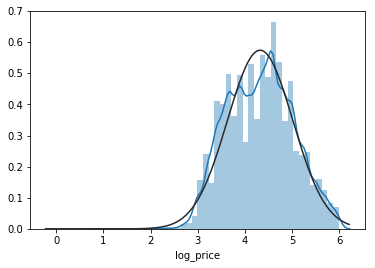

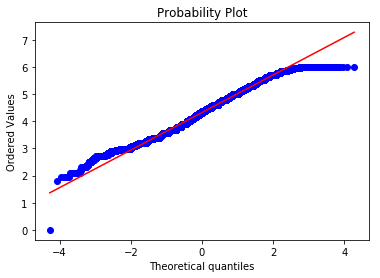

In [17]:
sns.distplot(listings['log_price'], fit=norm);
fig = plt.figure()
fig.savefig("logprice.png")
res = stats.probplot(listings['log_price'], plot=plt)
fig.savefig("logprob.png")

In [18]:
print("Skewness: %f" % listings['price'].skew())
print("Kurtosis: %f" % listings['price'].kurt())

Skewness: 1.626154
Kurtosis: 2.945136


#### Data Preprocessing

In [19]:
#define a new dataframe to do the cleaning on:
listings_clean = listings 

In [20]:
listings_clean.shape

(72689, 97)

In [21]:
listings_clean.drop(['host_acceptance_rate','jurisdiction_names', 'neighbourhood_group_cleansed','thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url'], axis = 1, inplace=True)


In [22]:
listings_clean.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_inc

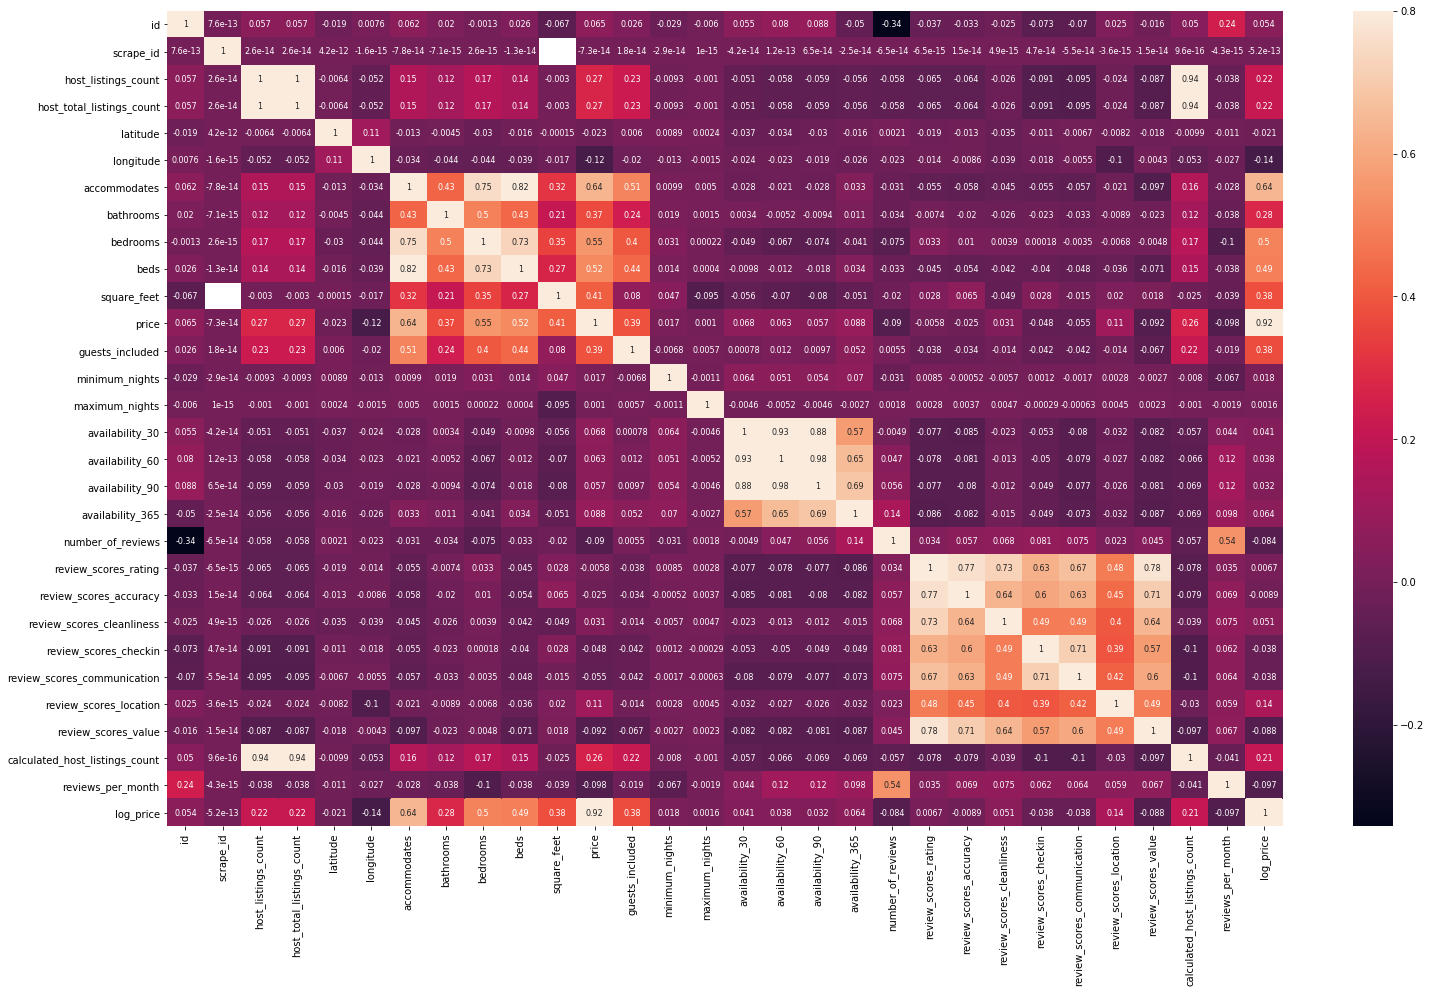

In [23]:
corr = listings_clean.corr()
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr, vmax=.8, annot_kws={'size': 8},annot=True);

This was much information. To have a clearer view of the correlations I will "zoom" in on the 15 columns with highest positive scores

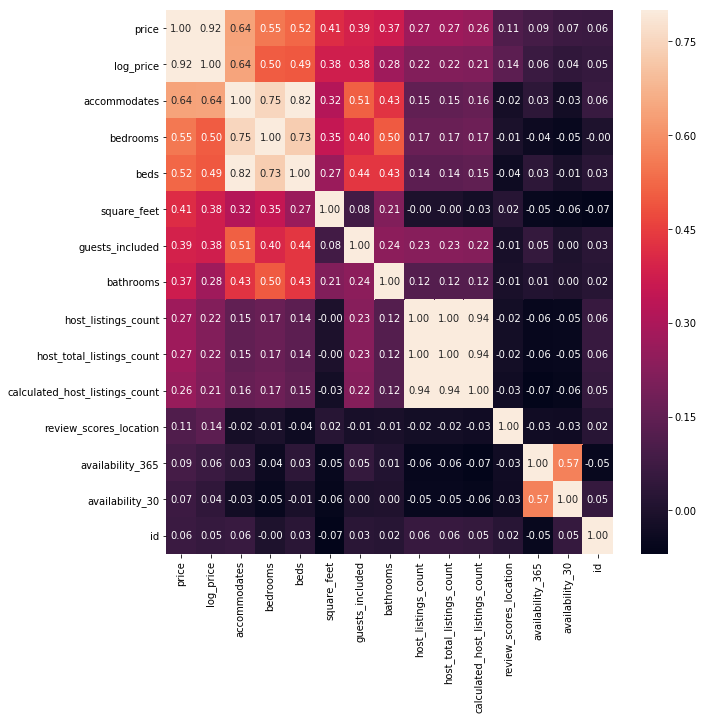

In [24]:
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'price')['price'].index
corr_h=listings_clean[cols].corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_h, vmax=.8, fmt='.2f', annot_kws={'size': 10},annot=True);


**Distributions and detecting outliers**

In [25]:
listings_clean[cols].describe()

,price,log_price,accommodates,bedrooms,beds,square_feet,guests_included,bathrooms,host_listings_count,host_total_listings_count,calculated_host_listings_count,review_scores_location,availability_365,availability_30,id
count,72689.000000,72689.000000,72689.000000,72640.000000,72523.000000,467.000000,72689.000000,72504.000000,72654.000000,72654.000000,72689.000000,53174.000000,72689.000000,72689.000000,7.268900e+04
mean,96.071579,4.325810,3.070712,1.367263,1.719634,605.650964,1.513613,1.261765,27.003826,27.003826,21.855067,9.455091,122.026648,7.386867,1.718682e+07
std,70.593296,0.694902,1.869521,0.841065,1.166476,804.775516,1.175479,0.559323,153.528550,153.528550,123.312216,0.855346,135.218115,9.992329,8.127119e+06
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,9.554000e+03
25%,45.000000,3.806662,2.000000,1.000000,1.000000,124.500000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,0.000000,0.000000,1.093854e+07
50%,77.000000,4.343805,2.000000,1.000000,1.000000,484.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,65.000000,1.000000,1.878634e+07
75%,125.000000,4.828314,4.000000,2.000000,2.000000,807.000000,2.000000,1.500000,4.000000,4.000000,4.000000,10.000000,260.000000,13.000000,2.391982e+07
max,400.000000,5.991465,16.000000,12.000000,16.000000,10710.000000,24.000000,14.000000,1493.000000,1493.000000,1080.000000,10.000000,365.000000,30.000000,2.905959e+07


In [26]:
#outliers:
#square feet seems to have some outliers, however, due to the large number of missing fields this will be removed anyway

C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


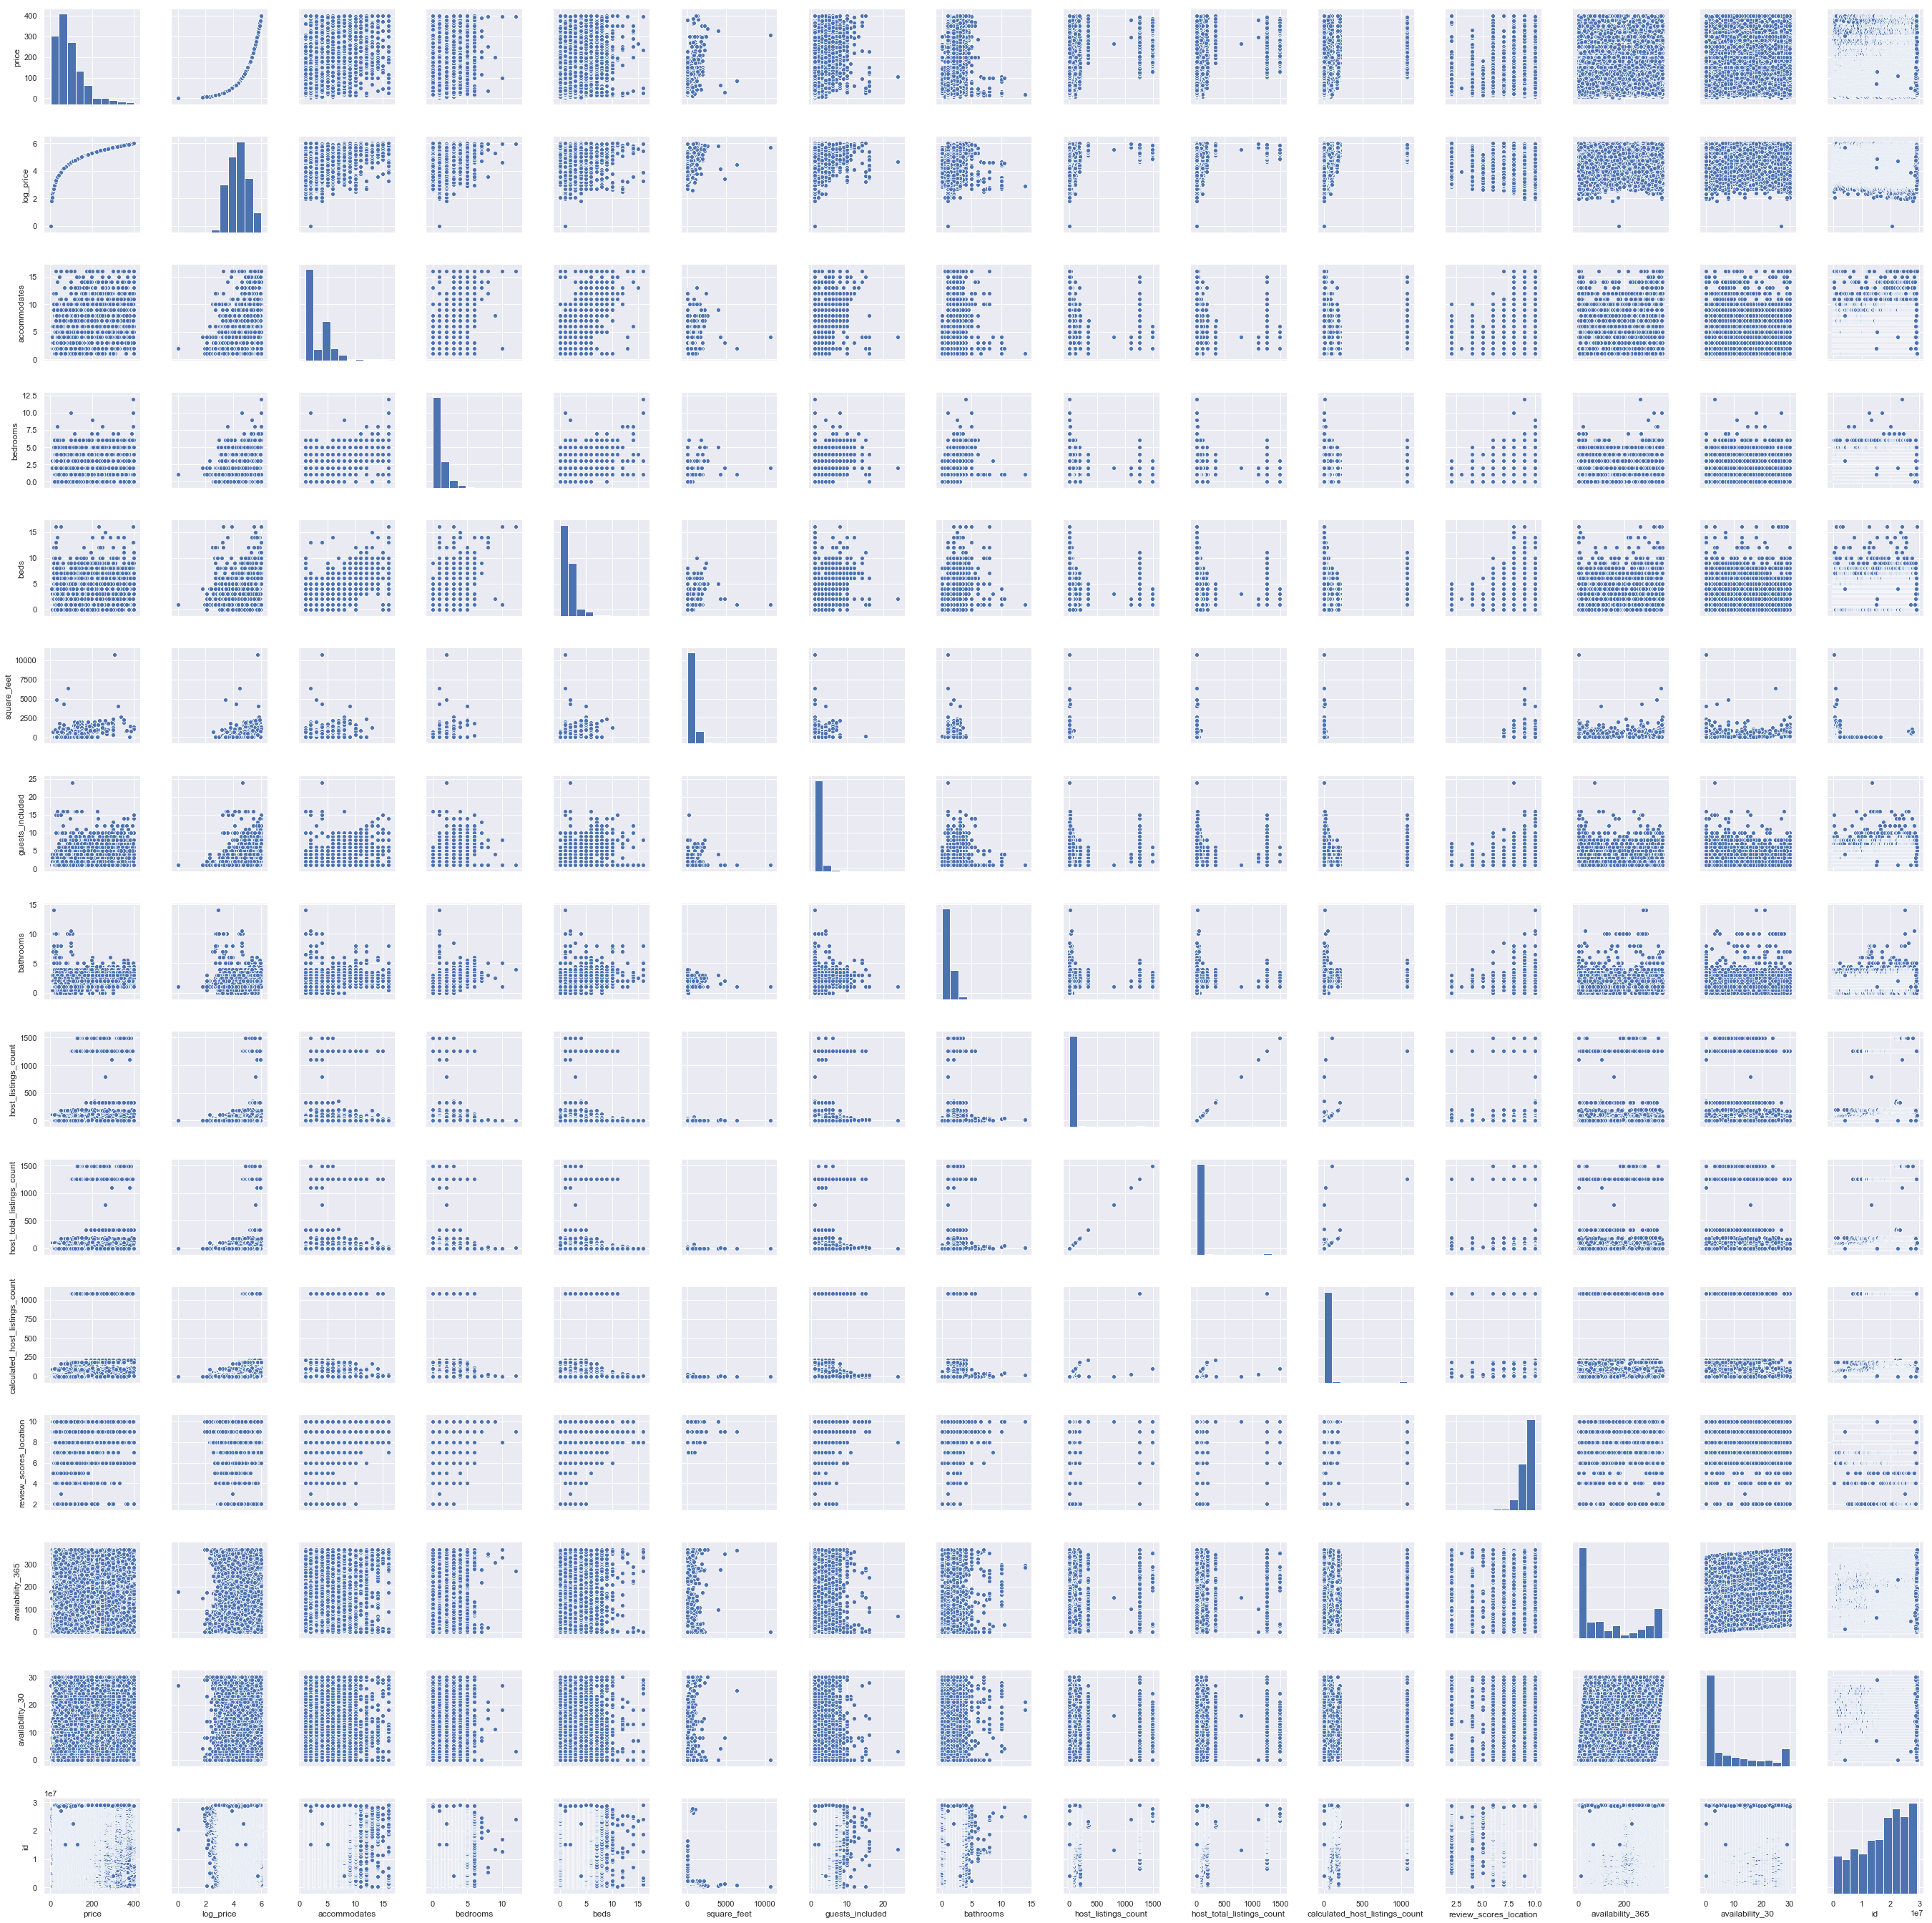

In [27]:
#scatterplot
sns.set()
sns.pairplot(listings_clean[cols], height = 2.5)
plt.show();

In [28]:
#missing values
attributes = pd.DataFrame(listings_clean.isnull().sum().sort_values(ascending=False),columns=['n_nan'])
attributes['share_nan'] =attributes['n_nan']/listings_clean.shape[0]*100
attributes.reset_index(inplace=True)
attributes_highnan = attributes.head(30)
attributes_highnan

,index,n_nan,share_nan
0,license,72542,99.797769
1,square_feet,72222,99.357537
2,monthly_price,66564,91.573691
3,weekly_price,64181,88.295340
4,notes,43798,60.253959
5,host_response_rate,33337,45.862510
6,host_response_time,33336,45.861134
7,interaction,32417,44.596844
8,access,30236,41.596390
9,host_about,30064,41.359766


Text(0, 0.5, 'Attributes')

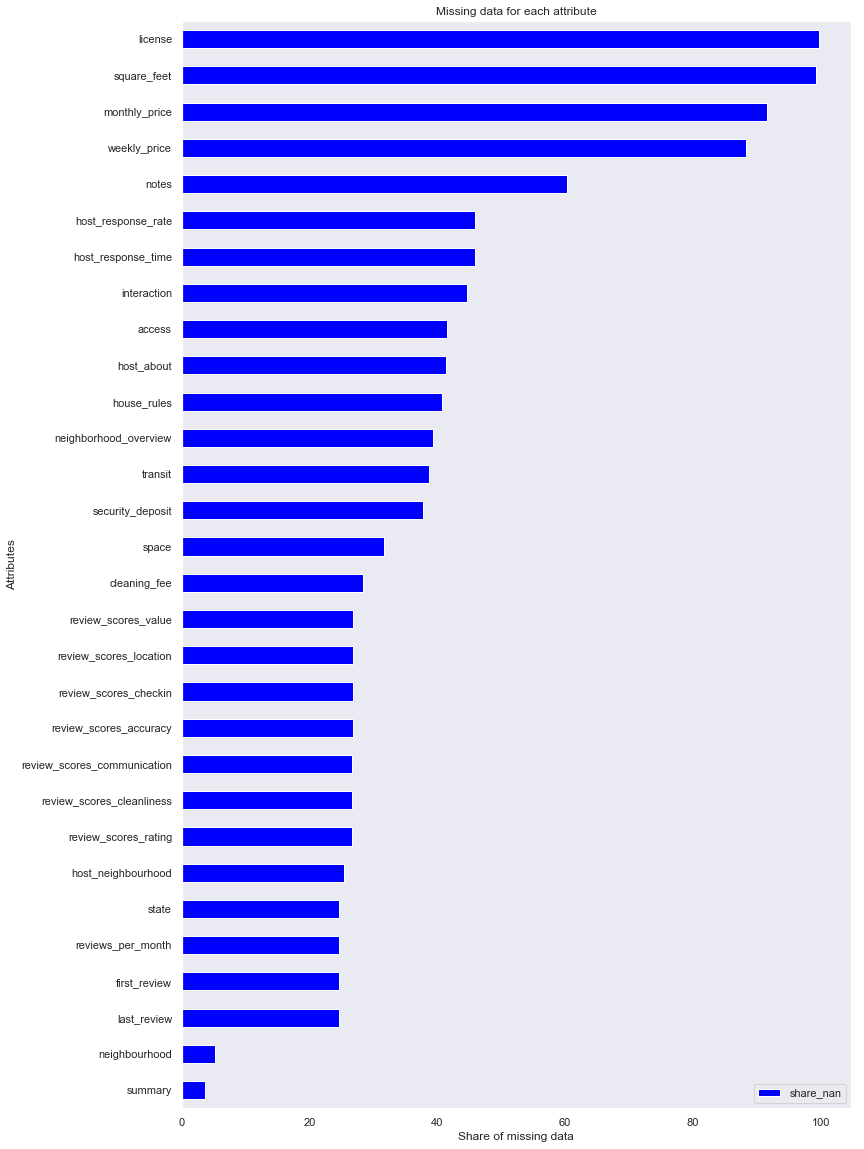

In [29]:
attr_plot= attributes_highnan.sort_values('share_nan', ascending=True)
attr_plot.plot.barh(x='index', y='share_nan', figsize=(12, 20), color='blue',grid=False)
plt.title('Missing data for each attribute')
plt.xlabel('Share of missing data')
plt.ylabel('Attributes')

In [30]:
#make some new columns with binaries instead of multi categorical or floats
listings_clean['b_transit']= listings_clean['transit'].apply(lambda x:1 if not pd.isnull(x) else 0)
listings_clean['b_host_about']= listings_clean['host_about'].apply(lambda x:1 if not pd.isnull(x) else 0)
listings_clean['b_cleaning_fee']= listings_clean['cleaning_fee'].apply(lambda x:1 if not pd.isnull(x) else 0)
listings_clean['b_security_deposit']= listings_clean['security_deposit'].apply(lambda x:1 if not pd.isnull(x) else 0)
listings_clean['b_access']= listings_clean['access'].apply(lambda x:1 if not pd.isnull(x) else 0)
listings_clean['b_interaction']= listings_clean['interaction'].apply(lambda x:1 if not pd.isnull(x) else 0)
listings_clean['b_house_rules']= listings_clean['house_rules'].apply(lambda x:1 if not pd.isnull(x) else 0)

In [31]:
listings_clean['b_security_deposit']= listings_clean['security_deposit'].apply(lambda x:1 if not pd.isnull(x) else 0)

In [32]:
listings_clean['amenities']

0        {TV,Internet,Wifi,Kitchen,"Smoking allowed",Br...
1        {TV,"Cable TV",Internet,Wifi,Breakfast,"Pets l...
2        {TV,Internet,Wifi,Kitchen,"Buzzer/wireless int...
3        {TV,"Cable TV",Wifi,Kitchen,"Paid parking off ...
4        {TV,Wifi,"Free parking on premises",Breakfast,...
5        {Internet,Wifi,Kitchen,Heating,Washer,"transla...
6        {TV,Internet,Wifi,Kitchen,Elevator,"Buzzer/wir...
7        {TV,Wifi,Kitchen,"Smoking allowed",Heating,Was...
8        {"Cable TV",Wifi,Kitchen,"Paid parking off pre...
9        {TV,Wifi,Kitchen,"Paid parking off premises",E...
10       {Wifi,Kitchen,"Buzzer/wireless intercom",Heati...
11       {TV,Wifi,Kitchen,Breakfast,Heating,Washer,"Smo...
12       {TV,Internet,Wifi,Kitchen,"Paid parking off pr...
13       {TV,"Cable TV",Internet,Wifi,Kitchen,"Free par...
14       {TV,"Cable TV",Internet,Wifi,Kitchen,"Free par...
15       {TV,Internet,Wifi,Kitchen,"Free parking on pre...
16       {TV,"Cable TV",Internet,Wifi,Kitchen,Elevator,.

In [33]:
#choosing to display some of the amenities as own columns
listings_clean['TV'] = listings_clean.amenities.apply(lambda x:1 if 'TV' in str(x)[1:] else 0)
listings_clean['Wifi'] = listings_clean.amenities.apply(lambda x:1 if 'Wifi' in str(x)[1:] else 0)
listings_clean['Parking'] =listings_clean.amenities.apply(lambda x:1 if 'Free parking' in str(x)[1:] else 0)
listings_clean['AC'] =listings_clean.amenities.apply(lambda x:1 if 'Air conditioning' in str(x)[1:] else 0)
listings_clean['Kitchen'] =listings_clean.amenities.apply(lambda x:1 if 'Kitchen' in str(x)[1:] else 0)

#count number of amenities
listings_clean['amenities_count'] =listings_clean.amenities.apply(lambda x:len(x.split(',')))

In [34]:
#1/0 instead of true/false
listings_clean['host_is_superhost']= listings_clean['host_is_superhost'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['host_has_profile_pic']= listings_clean['host_has_profile_pic'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['host_identity_verified']= listings_clean['host_identity_verified'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['is_location_exact']= listings_clean['is_location_exact'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['requires_license']= listings_clean['requires_license'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['instant_bookable']= listings_clean['instant_bookable'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['require_guest_profile_picture']= listings_clean['require_guest_profile_picture'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['require_guest_phone_verification']= listings_clean['require_guest_phone_verification'].apply(lambda x:1 if 't' in str(x) else 0)
listings_clean['has_availability']= listings_clean['has_availability'].apply(lambda x:1 if 't' in str(x) else 0)

In [35]:
#convert to date format:
listings_clean['host_since'] = pd.to_datetime(listings_clean['host_since'])
listings_clean['first_review'] = pd.to_datetime(listings_clean['first_review'])
listings_clean['last_review'] = pd.to_datetime(listings_clean['last_review'])
listings_clean[['host_response_rate']] = listings_clean[['host_response_rate']].replace('[\%,]','',regex=True).astype(float)


In [36]:
#convert to float:
listings_clean[['cleaning_fee']] = listings_clean[['cleaning_fee']].replace('[\$,]','',regex=True).astype(float)
listings_clean[['extra_people']] = listings_clean[['extra_people']].replace('[\$,]','',regex=True).astype(float)

In [37]:
#delete unnecessary columns, columns with high share of nans etc. 
listings_clean.drop(['listing_url', 'scrape_id', 'last_scraped','summary', 'description','street', 'host_verifications', 'neighbourhood', 'name', 'space','transit', 'host_about', 'host_picture_url', 'host_thumbnail_url', 'host_name','square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'access', 'interaction', 'notes','latitude', 'longitude', 'country', 'market' , 'house_rules'], axis = 1, inplace=True)

listings_clean.drop(['cleaning_fee', 'host_listings_count','license','calendar_updated','host_neighbourhood', 'experiences_offered', 'neighborhood_overview', 'amenities', 'calendar_last_scraped'], axis = 1, inplace=True)

listings_clean.drop(['maximum_nights', 'host_location', 'city', 'state', 'smart_location','zipcode', 'country_code'], axis = 1, inplace=True)

#### Feature Engineering

In [38]:
# Split the data into features and target label
df_target = listings_clean['log_price']

In [39]:
features_raw = listings_clean.drop(['price', 'log_price' , 'id'],  axis = 1)

In [40]:
pd.set_option('display.max_columns', None)
features_raw.head()

,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,extra_people,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,b_transit,b_host_about,b_cleaning_fee,b_security_deposit,b_access,b_interaction,b_house_rules,TV,Wifi,Parking,AC,Kitchen,amenities_count
0,2009-08-14,within an hour,100.0,1,4.0,1,0,Haringey,0,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,1,15.0,1,1,0,0,24,299,133,2012-04-26,2018-08-13,97.0,10.0,9.0,10.0,10.0,9.0,10.0,0,0,f,strict_14_with_grace_period,1,0,4,1.69,1,1,1,0,1,1,1,1,1,0,0,1,18
1,2009-09-22,NaN,NaN,0,6.0,1,0,Ealing,1,Apartment,Private room,2,NaN,1.0,1.0,Real Bed,2,35.0,2,1,14,14,14,14,2,2016-04-05,2016-11-23,90.0,8.0,9.0,10.0,9.0,9.0,9.0,0,1,f,strict_14_with_grace_period,0,0,6,0.07,1,1,0,0,1,1,1,1,1,0,0,0,11
2,2011-04-06,within an hour,100.0,0,3.0,1,0,Westminster,1,Apartment,Entire home/apt,5,1.0,1.0,3.0,Real Bed,1,0.0,4,1,3,18,30,289,9,2015-01-08,2018-05-14,87.0,9.0,8.0,10.0,10.0,10.0,9.0,0,1,f,strict_14_with_grace_period,0,0,2,0.20,1,1,1,0,1,1,1,1,1,0,0,1,19
3,2009-11-16,within an hour,85.0,0,4.0,1,0,Islington,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,1,15.0,1,1,29,59,89,364,14,2010-08-18,2018-06-17,95.0,9.0,10.0,9.0,10.0,9.0,9.0,0,0,f,moderate,0,0,3,0.14,1,1,1,1,1,1,1,1,1,0,0,1,54
4,2011-04-07,within an hour,100.0,0,1.0,1,1,Lewisham,1,Loft,Private room,3,1.0,1.0,1.0,Real Bed,1,25.0,2,1,9,31,47,318,50,2012-11-05,2018-09-28,95.0,10.0,10.0,10.0,10.0,9.0,9.0,0,0,f,moderate,0,0,1,0.69,1,1,1,1,1,1,1,1,1,1,0,0,22


In [41]:
#dummy variables - onehotencoder of the categorical features:
features_final = pd.get_dummies(features_raw)

In [42]:
#fills nan values with zero in the features final:
ff = features_final.select_dtypes(include=['int64','float64','uint8']).copy()
fill = lambda col: col.fillna(0)
ff = ff.apply(fill, axis=0)

In [43]:
ff.head()

,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,b_transit,b_host_about,b_cleaning_fee,b_security_deposit,b_access,b_interaction,b_house_rules,TV,Wifi,Parking,AC,Kitchen,amenities_count,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Barking and Dagenham,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Dorm,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Igloo,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Parking Space,property_type_Resort,property_type_Ryokan (Japan),property_type_Serviced apartment,"property_type_Shepherd's hut (U.K., France)",property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,100.0,1,4.0,1,0,0,2,0.0,1.0,1.0,1,15.0,1,1,0,0,24,299,133,97.0,10.0,9.0,10.0,10.0,9.0,10.0,0,0,1,0,4,1.69,1,1,1,0,1,1,1,1,1,0,0,1,18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
1,0.0,0,6.0,1,0,1,2,0.0,1.0,1.0,2,35.0,2,1,14,14,14,14,2,90.0,8.0,9.0,10.0,9.0,9.0,9.0,0,1,0,0,6,0.07,1,1,0,0,1,1,1,1,1,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [44]:
#summary statistics of the quantitative variables in the dataset

ff.describe()

,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,b_transit,b_host_about,b_cleaning_fee,b_security_deposit,b_access,b_interaction,b_house_rules,TV,Wifi,Parking,AC,Kitchen,amenities_count,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Barking and Dagenham,neighbourhood_cleansed_Barnet,neighbourhood_cleansed_Bexley,neighbourhood_cleansed_Brent,neighbourhood_cleansed_Bromley,neighbourhood_cleansed_Camden,neighbourhood_cleansed_City of London,neighbourhood_cleansed_Croydon,neighbourhood_cleansed_Ealing,neighbourhood_cleansed_Enfield,neighbourhood_cleansed_Greenwich,neighbourhood_cleansed_Hackney,neighbourhood_cleansed_Hammersmith and Fulham,neighbourhood_cleansed_Haringey,neighbourhood_cleansed_Harrow,neighbourhood_cleansed_Havering,neighbourhood_cleansed_Hillingdon,neighbourhood_cleansed_Hounslow,neighbourhood_cleansed_Islington,neighbourhood_cleansed_Kensington and Chelsea,neighbourhood_cleansed_Kingston upon Thames,neighbourhood_cleansed_Lambeth,neighbourhood_cleansed_Lewisham,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Dome house,property_type_Dorm,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Igloo,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Nature lodge,property_type_Other,property_type_Parking Space,property_type_Resort,property_type_Ryokan (Japan),property_type_Serviced apartment,"property_type_Shepherd's hut (U.K., France)",property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
count,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.0,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.0,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,72689.000000,726

In [45]:
#which scaler to choose? 
#will go with the MinMax scaler due to the 
data= ff.select_dtypes(include=['int64', 'float64', 'uint8']).copy()
scaler = MinMaxScaler()
df = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)

### Feature reduction

There are many features, and I will see if PCA can be used to reduce the number of features so simplify the subsequent modelling

In [46]:
pca = PCA()
pca_df = pca.fit_transform(df)


C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


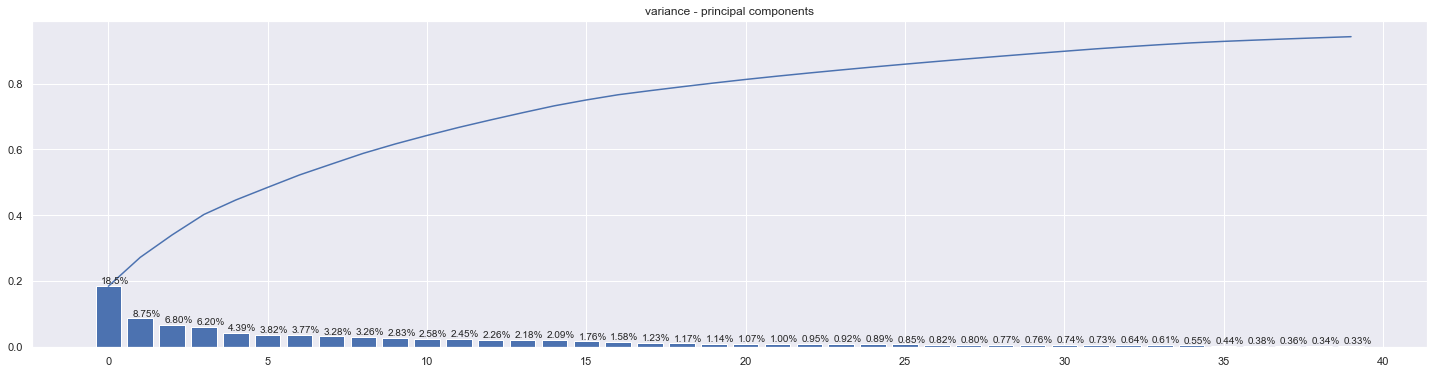

In [122]:
#function from lesson on pca in udacity course on unsupervised learning

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(25, 6))
    plt.title('variance - principal components')
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)

scree_plot(pca)

C:\Users\kjers\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


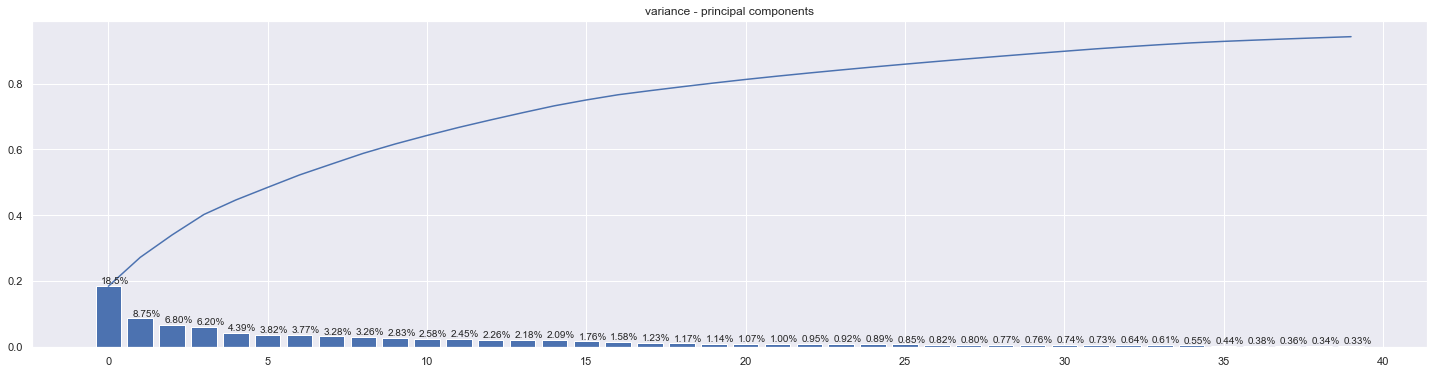

In [48]:
pca=PCA(n_components = 40)
pca_X = pca.fit_transform(df)
scree_plot(pca)

With 20 components about 80% of the variance in the dataset is explained. With 40 components about 90% is explained. 

**fit model with PCA dataset**

In [49]:
y=df_target
x=pca_X

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [50]:
#benchmark model
model = Ridge()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [51]:
#evaluation of the benchmark model

print('MSE train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.191, test: 0.187
R^2 train: 0.605, test: 0.609


,R Square Score
Bagging,0.640895
RandomForest,0.637809
AdaBoost,0.445669
GradBoost,0.632601
xgb,0.633008
Linear_ridge,0.603973
Hubber,0.603463


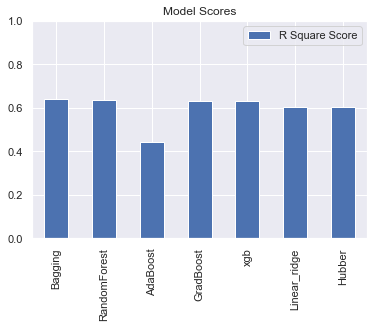

In [52]:
#testing a range of other models

def model(train, target):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=42)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, target, verbose=0, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = GradientBoostingRegressor()
    results["GradBoost"]=test_model(clf)

    #XGBoost is currently the dominant algorithm for building accurate models on conventional data 
    clf = XGBRegressor()
    results["xgb"]=test_model(clf)
    
    clf = Ridge()
    results["Linear_ridge"]=test_model(clf)

    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)

    
    results = pd.DataFrame.from_dict(results, orient='index', dtype=float)
    results.columns=["R Square Score"] 
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0,1])
    return results

model(X_train, y_train)

**without pca**

In [53]:
y=df_target
x=df

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

In [54]:
#linear regression
model = Ridge()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [55]:
print('MSE train: %.3f, test: %.3f' % (
       mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 0.133, test: 0.130
R^2 train: 0.725, test: 0.729


#### Model Testing and Selection

,R Square Score
Bagging,0.735734
RandomForest,0.736980
AdaBoost,0.466937
GradBoost,0.739261
xgb,0.739615
Linear_ridge,0.722869
Hubber,0.720891


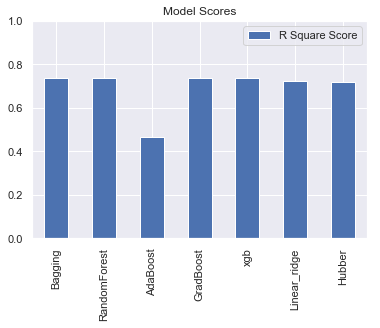

In [56]:
def model(train, target):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=42)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, target, verbose=0, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = GradientBoostingRegressor()
    results["GradBoost"]=test_model(clf)

    #
    clf = XGBRegressor()
    results["xgb"]=test_model(clf)
    
    clf = Ridge()
    results["Linear_ridge"]=test_model(clf)

    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)

    
    results = pd.DataFrame.from_dict(results, orient='index', dtype=float)
    results.columns=["R Square Score"] 
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0,1])
    return results

model(X_train, y_train)

#### Model Tuning

In [63]:
"""""""""
GridSearchCV implements a “fit” and a “score” method. 
It also implements “predict”
"""""""""

cv = KFold(n_splits=5,shuffle=True,random_state=42)

parameters = {'learning_rate': [0.01,0.1],
              'n_estimators' : [500,1000,1500],
              'max_depth' : [5,6,7],
              'gamma': [0,0.1]}

clf = XGBRegressor()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv=cv,scoring=r2)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_ 


best_clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [64]:
print(grid_fit.best_score_)

0.7835667481747163


#### Results and Conclusions

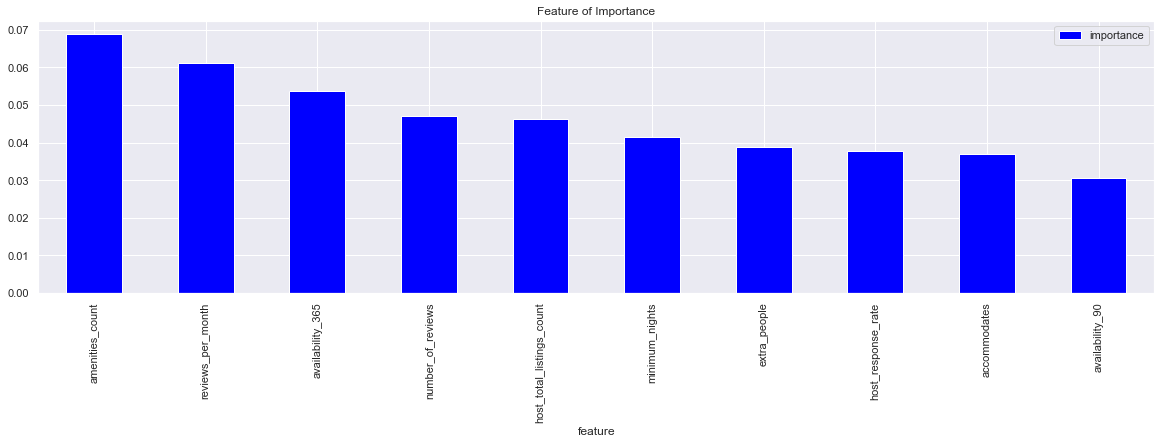

In [65]:
importances = best_clf.feature_importances_
feat_names = X_train.columns
result = pd.DataFrame({'feature': feat_names, 'importance': importances})
result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',figsize=(20,5), color='blue', title='Feature of Importance')

In [82]:
#sanity check
y_test = best_clf.predict(X_test)

In [105]:
pred = pd.DataFrame()

pred['index'] = X_test.index
pred['Price'] = np.expm1(y_test)

pred.head(5)

,index,Price
0,72265,185.770279
1,40121,181.197540
2,72070,184.348541
3,49452,46.028320
4,21835,79.828621


In [119]:
listings['id'].loc[72265]

28574425

In [120]:
listings[listings['id']==28574425]

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,log_price,b_transit,b_host_about,b_cleaning_fee,b_security_deposit,b_access,b_interaction,b_house_rules,TV,Wifi,Parking,AC,Kitchen,amenities_count
72265,28574425,2018-01-03,within an hour,100.0,0,52.0,1,0,Westminster,0,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,195.0,2,50.0,3,1,0,29,59,334,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,f,strict_14_with_grace_period,0,0,50,NaN,5.273,0,1,1,1,0,0,0,1,1,0,0,1,23


the pricing seems reasonable in the test listing. Price was predicted to 186 and had a real price of 195. 

#### Improvements

Seasonality in pricing should also be investigated to have a more robust price recommender. 
The calendar dataset shows bookings one year ahead. I will investigate and see if we can find some seasonality patterns and discuss methods this could be investigated more thoroughly. 

In [84]:
calendar.shape

(27063655, 4)

In [85]:
calendar.head()

,listing_id,date,available,price
0,90663,2019-10-03,t,$136.00
1,9554,2019-09-20,t,$39.00
2,9554,2019-09-19,t,$35.00
3,9554,2019-09-18,t,$35.00
4,9554,2019-09-17,t,$35.00


In [86]:
calendar['date'] = pd.to_datetime(calendar['date'])


calendar[['price']] = calendar[['price']].replace('[\$,]','',regex=True).astype(float)

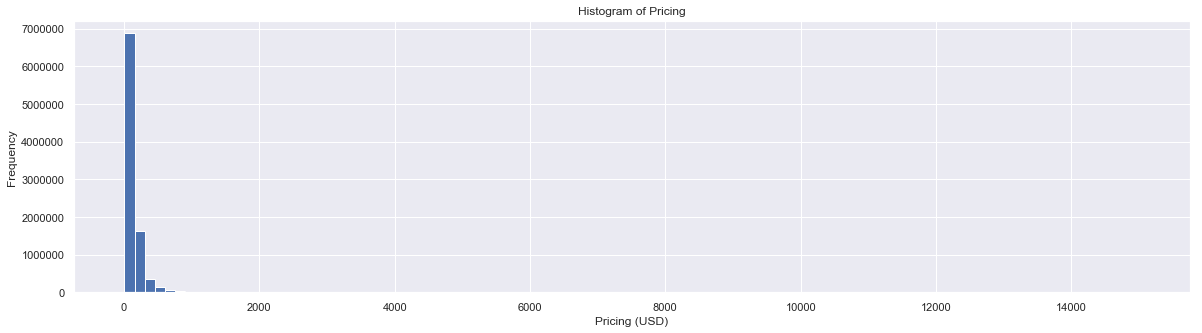

In [87]:
#price frequency
calendar['l_price'] = np.log(calendar['price'].values)
grouped = calendar.groupby(['listing_id'], as_index = False)

means = grouped['price'].mean().values
log_means = grouped['l_price'].mean().values

calendar['price'].hist(bins=100, figsize = (20,5))
plt.title("Histogram of Pricing")
plt.xlabel("Pricing (USD)")
plt.ylabel("Frequency")
plt.show()



**Patterns in price**

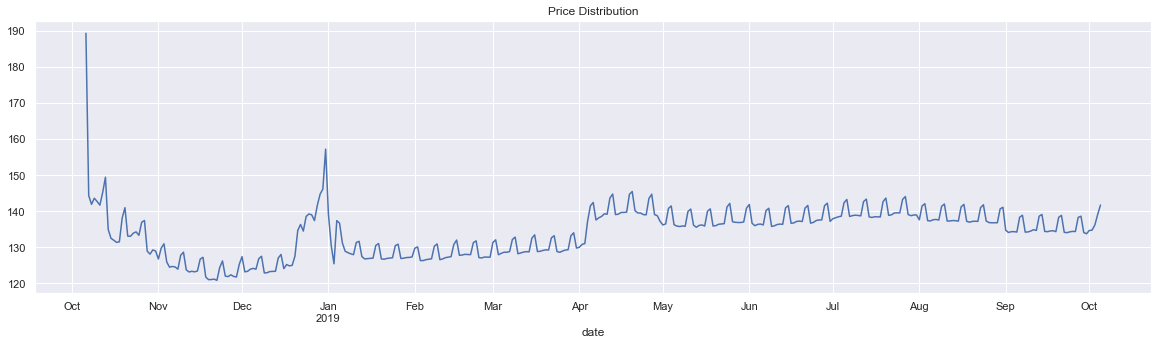

In [88]:
rented = calendar[calendar['available']=='t']
calendar_price = rented.groupby(rented['date'])['price'].mean()
plt.title('Price Distribution')
calendar_price.plot(kind = 'line' , figsize = (20,5));

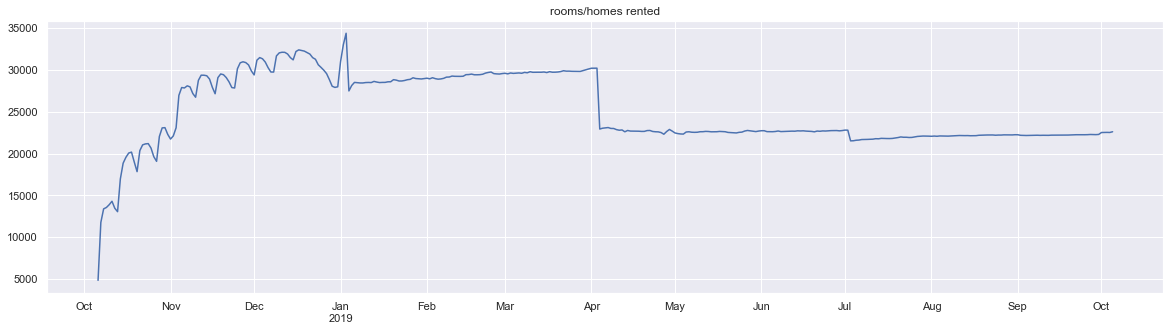

In [89]:
calendar_counts = rented['date'].value_counts().sort_index()
plt.title('rooms/homes rented')
distr = calendar_counts.plot(kind = 'line' , figsize = (20,5));

In [90]:
booked = calendar[calendar['available']=='t']

In [91]:
booked.shape

(9136087, 5)

In [92]:
#Assess differences in price according to weekdays:
weekdays= calendar.groupby(calendar['date'].dt.strftime('%a'), sort=False)['price'].mean()

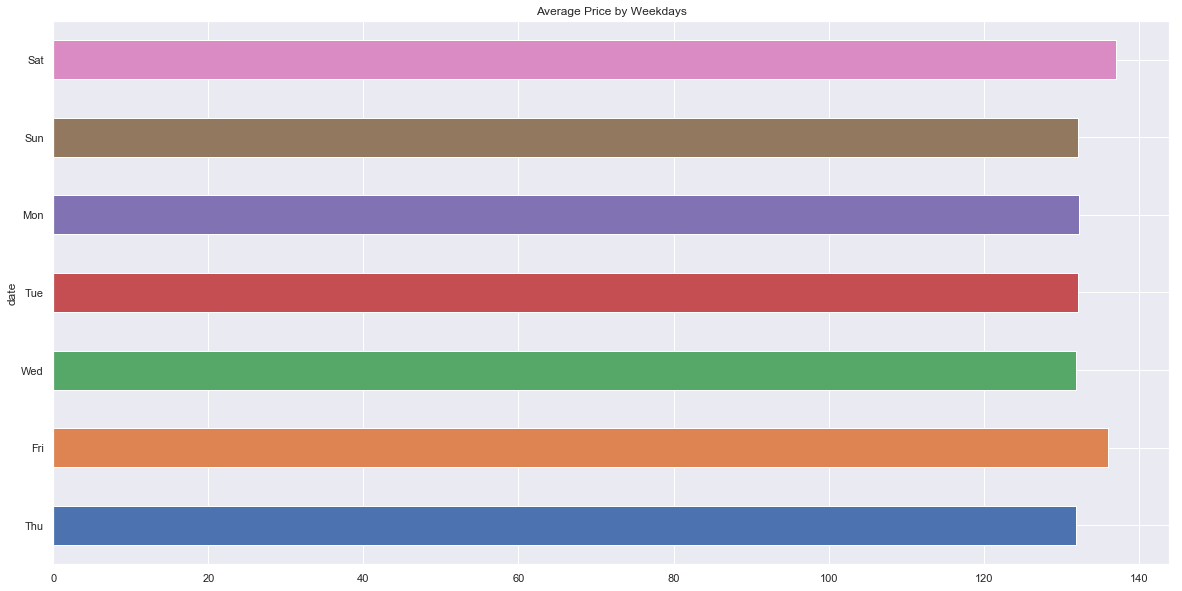

In [93]:
#display weekdays and price: 
plt.title('Average Price by Weekdays')
weekdays.plot(kind = 'barh' , figsize = (20,10));
